## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.<br>
Отделу цифровых технологий поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.<br>
С помощью трех датасетов создадим модели машинного обучения, которые предскажут вероятность снижения покупательской активности клиента в следующие три месяца и выберем лучшую из них:<br>
1. "market_file" - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
2. "market_money" - таблица с данными о выручке, которую получает магазин с покупателя
3. "market_time" - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода

<font color='red'>Задача</font>: Используя данные модели и данные о прибыльности клиентов (четвертая таблица - "money"), нужно выделить сегменты покупателей и разработать для них персонализированные предложения

## Загрузка данных

In [1]:
!pip install shap
!pip install scikit-learn==1.5
!pip install phik 

In [2]:
import pandas as pd
import phik
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sklearn

from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_file.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

### Таблица с данными о выручке, которую получает магазин с покупателя

In [5]:
market_money = pd.read_csv('/datasets/market_money.csv')
market_money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


### Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [7]:
market_time = pd.read_csv('/datasets/market_time.csv')
market_time.head(5)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


### Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца

In [9]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
money.head(5)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [10]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### <font color='red'>Вывод</font><br>
<div class="alert alert-info">
    1. Таблица 'market_file' содержит 1300 строк и 13 столбцов, из которых: 9 - числовые(int или float), 4 - строковые(oject).<br>
    2. Таблица 'market_money' содержит 3900 строк и 3 столбца, из которых: 2 - числовые, 1 - строковый.<br>
    3. Таблица 'market_time' содержит 2600 строк и 3 столбца, из которых: 2 - числовые, 1 - строковый.<br>
    4. Таблица 'money' имеет 1300 строк и 2 столбца и оба числовые.<br>
    5. Во всех таблицах данные столбцов соответствуют их типу данных, названия столбцов нужно привести к нижнему и "змеиному" регистру и судя по всему не содержат пропущенных значий, но это более точно проверим в следующем пункте

## Предобработка данных

### Проверим таблицы на пропущенные значения

#### market_file

In [11]:
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

#### market_money

In [12]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

#### market_time

In [13]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

#### money

In [14]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

### Проверим таблицы на дубликаты

#### market_file

In [15]:
market_file.duplicated().sum()

0

#### market_money

In [16]:
market_money.duplicated().sum()

0

#### market_time

In [17]:
market_time.duplicated().sum()

0

#### money

In [18]:
money.duplicated().sum()

0

#### Проверим таблицы на неявные дубликаты(опечатки, разные регистры и т.д.)

In [19]:
def duplicate_columns(data):
    """Функция проверки столбцов на неявные дубликаты."""
    list_columns = data.select_dtypes(exclude='number').columns.tolist()
    for col in list_columns:
        print(f'Столбец "{col}" имеет такие уникальные значения:', data[col].unique())

In [20]:
duplicate_columns(market_file)

Столбец "Покупательская активность" имеет такие уникальные значения: ['Снизилась' 'Прежний уровень']
Столбец "Тип сервиса" имеет такие уникальные значения: ['премиум' 'стандартт' 'стандарт']
Столбец "Разрешить сообщать" имеет такие уникальные значения: ['да' 'нет']
Столбец "Популярная_категория" имеет такие уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [21]:
duplicate_columns(market_money)

Столбец "Период" имеет такие уникальные значения: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [22]:
duplicate_columns(market_time)

Столбец "Период" имеет такие уникальные значения: ['текущий_месяц' 'предыдцщий_месяц']


In [23]:
# Нашли опечатку в столбце "Тип сервиса", заменим значение с "стандартт" на "стандарт"
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

### Переведем названия столбцов в нижний  и "змеиный" регистр

In [24]:
market_file.columns = market_file.columns.str.lower()
market_file.columns

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [25]:
market_money.columns = market_money.columns.str.lower()
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [26]:
market_time.columns = market_time.columns.str.lower()
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [27]:
money.columns = money.columns.str.lower()
money.columns

Index(['id', 'прибыль'], dtype='object')

In [28]:
market_file.columns = market_file.columns.str.replace(' ', '_')
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [29]:
"""В таблице "market_file" переведем названия столбцов в "змеиный" регистр
market_file.columns = [
    'id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать','маркет_актив_6_мес',
    'маркет_актив_тек_мес', 'длительность','акционные_покупки','популярная_категория',
    'средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса','страниц_за_визит'
]
market_file.columns"""

'В таблице "market_file" переведем названия столбцов в "змеиный" регистр\nmarket_file.columns = [\n    \'id\', \'покупательская_активность\', \'тип_сервиса\', \'разрешить_сообщать\',\'маркет_актив_6_мес\',\n    \'маркет_актив_тек_мес\', \'длительность\',\'акционные_покупки\',\'популярная_категория\',\n    \'средний_просмотр_категорий_за_визит\',\'неоплаченные_продукты_штук_квартал\',\n    \'ошибка_сервиса\',\'страниц_за_визит\'\n]\nmarket_file.columns'

### <font color='red'>Вывод</font><br>
<div class="alert alert-info">
    1. Во всех таблицах нет пропущенных значений.<br>
    2. В таблицах нет явных дубликатов, но нашли один неявный дубликат в таблице "market_file" в столбце "тип_сервиса".<br>
    3. Названия столбцов всех таблиц перевели в нижний и "змеиный" регистр

## Исследовательский анализ данных

In [30]:
def hist_boxplot(data):
    num_cols = data.select_dtypes(include='number').drop('id',axis=1).columns
    num_plots = len(num_cols)
    plt.figure(figsize=(20, 5 * num_plots))
    for i, col in enumerate(num_cols):
        plt.subplot(num_plots, 2, 2*i+1)
        data[col].hist(bins=20)
        plt.title(f'Гистограмма {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        
        plt.subplot(num_plots, 2, 2*i + 2)
        data.boxplot(column=col)
        plt.title(f'Диаграмма размаха {col}')
    
    plt.tight_layout()
    plt.show()

In [31]:
def count_cat_plot(data):
    cat_cols = data.select_dtypes(include='object').columns
    num_plots = len(cat_cols)
    plt.figure(figsize=(10, 5 * num_plots))
    for i, col in enumerate(cat_cols):
        plt.subplot(num_plots, 2, 2*i + 2)
        data[col].value_counts().plot.bar()
        plt.xlabel(col)
        plt.ylabel('Количество')
    
    plt.tight_layout()
    plt.show

### market_file

In [32]:
market_file.select_dtypes(include='number').drop('id', axis=1).describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


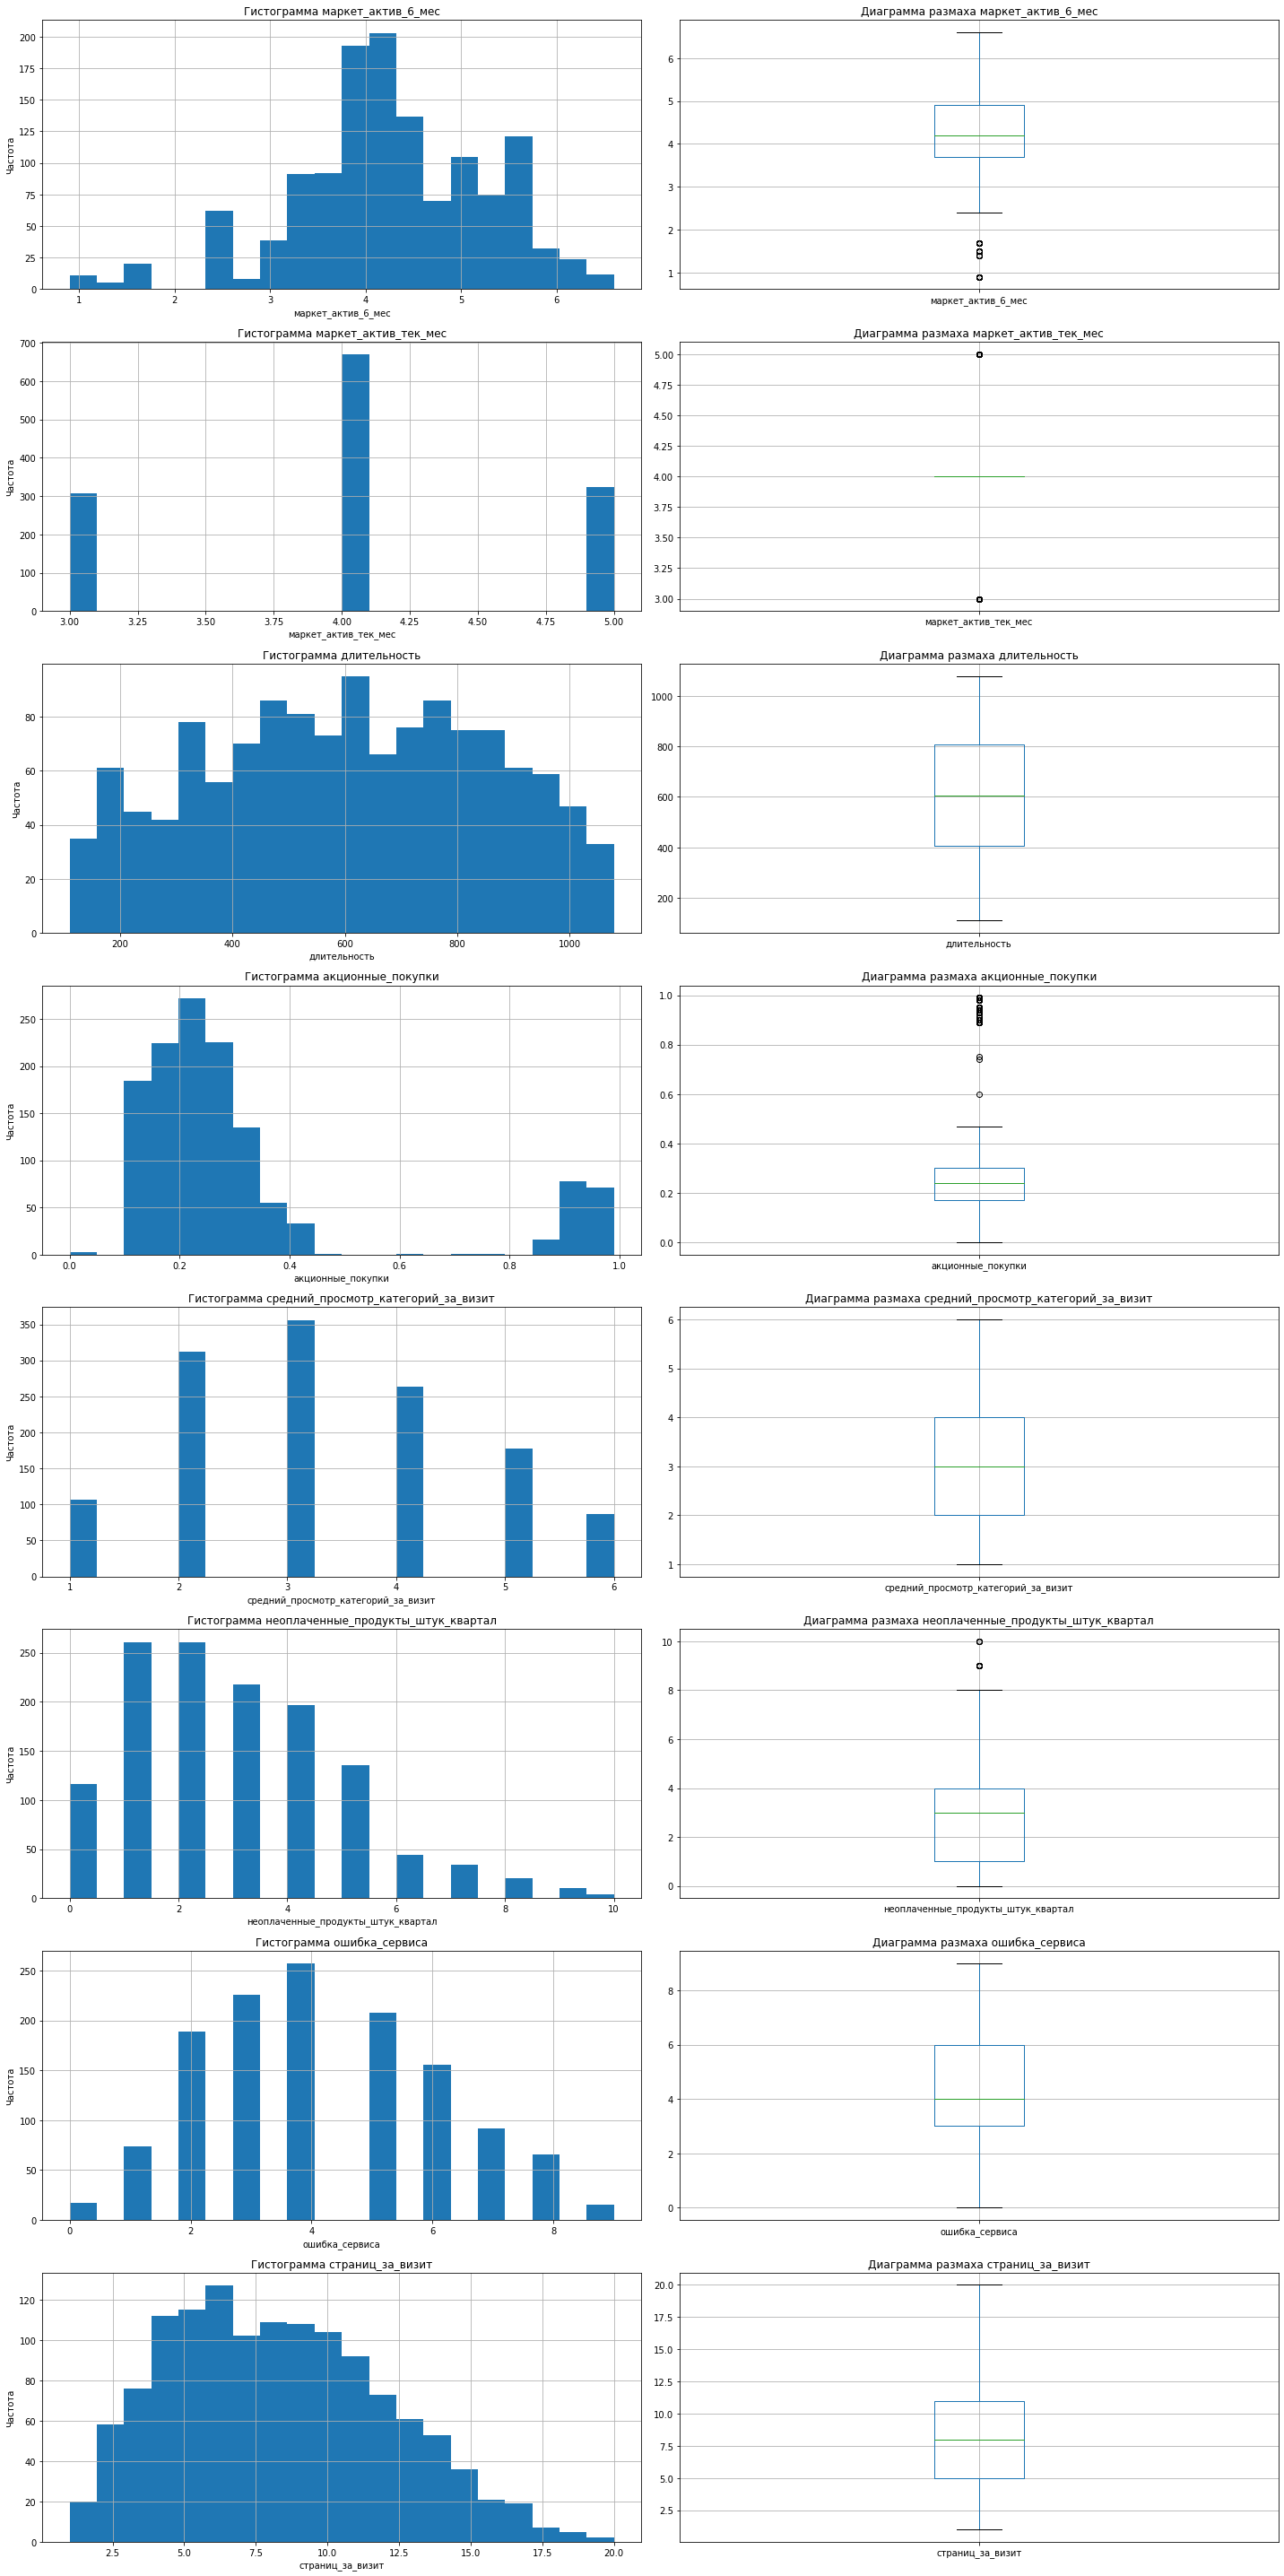

In [33]:
hist_boxplot(market_file)

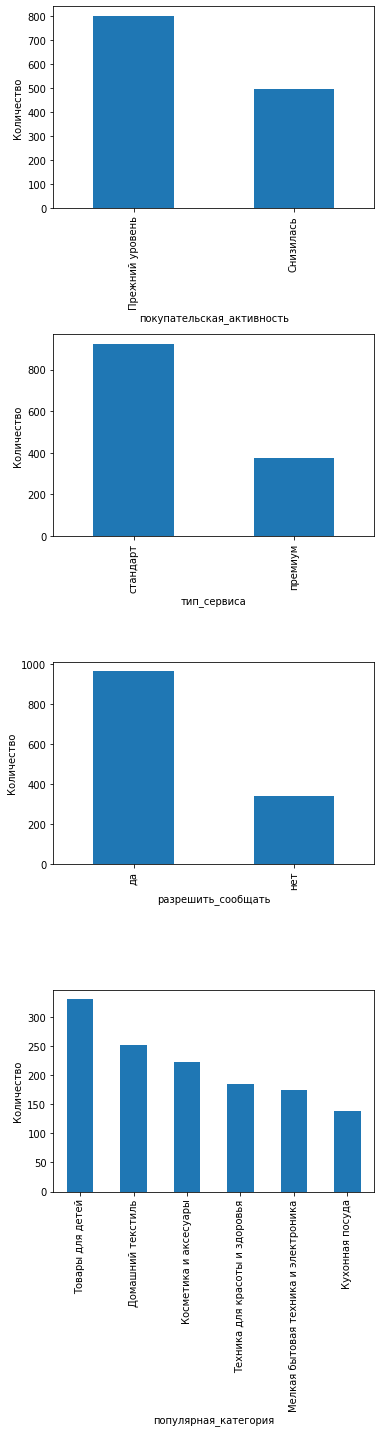

In [34]:
count_cat_plot(market_file)

В параметрах "маркет_актив_6_мес", "акционные_покупки", "неоплаченные_продукты_штук_квартал" присутствуют выбросы.<br>
В категориальных - присутствует дисбаланс значений

### market_money

In [35]:
market_money.select_dtypes(include='number').drop('id', axis=1).describe()

,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


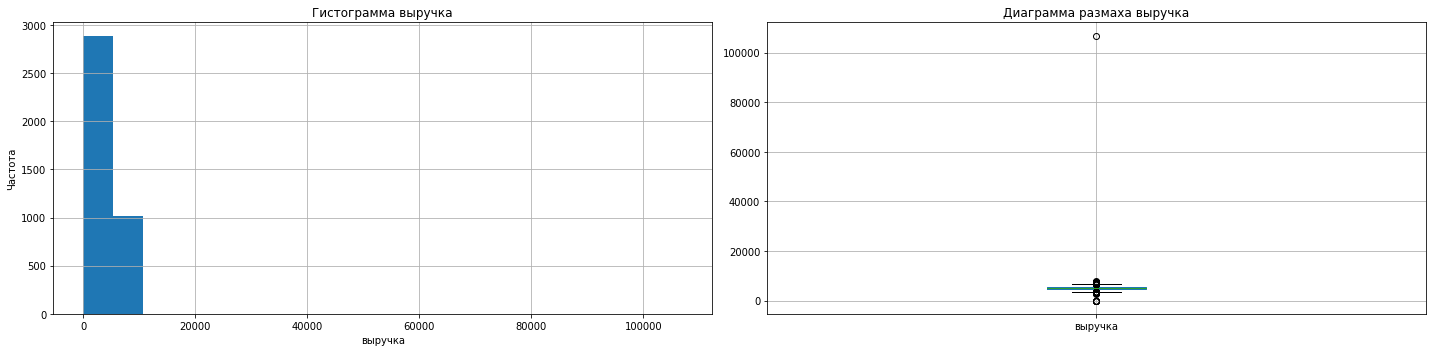

In [36]:
hist_boxplot(market_money)

In [37]:
market_money['выручка'].sort_values(ascending=False).head(5)

98      106862.2
435       7799.4
262       7605.3
1481      7557.0
2388      7547.8
Name: выручка, dtype: float64

In [38]:
market_money = market_money.drop(index=98, axis=0)
market_money['выручка'].sort_values(ascending=False).head(5)

435     7799.4
262     7605.3
1481    7557.0
2388    7547.8
566     7467.9
Name: выручка, dtype: float64

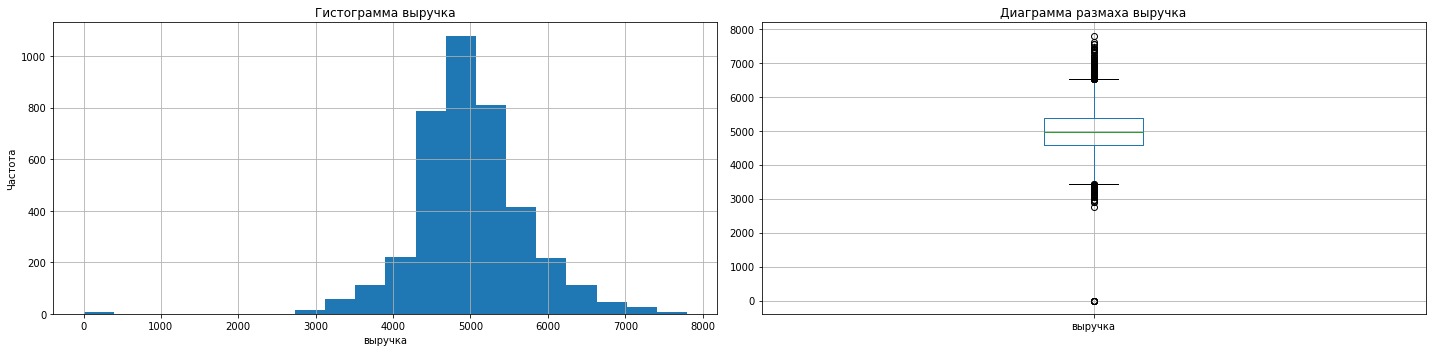

In [39]:
hist_boxplot(market_money)

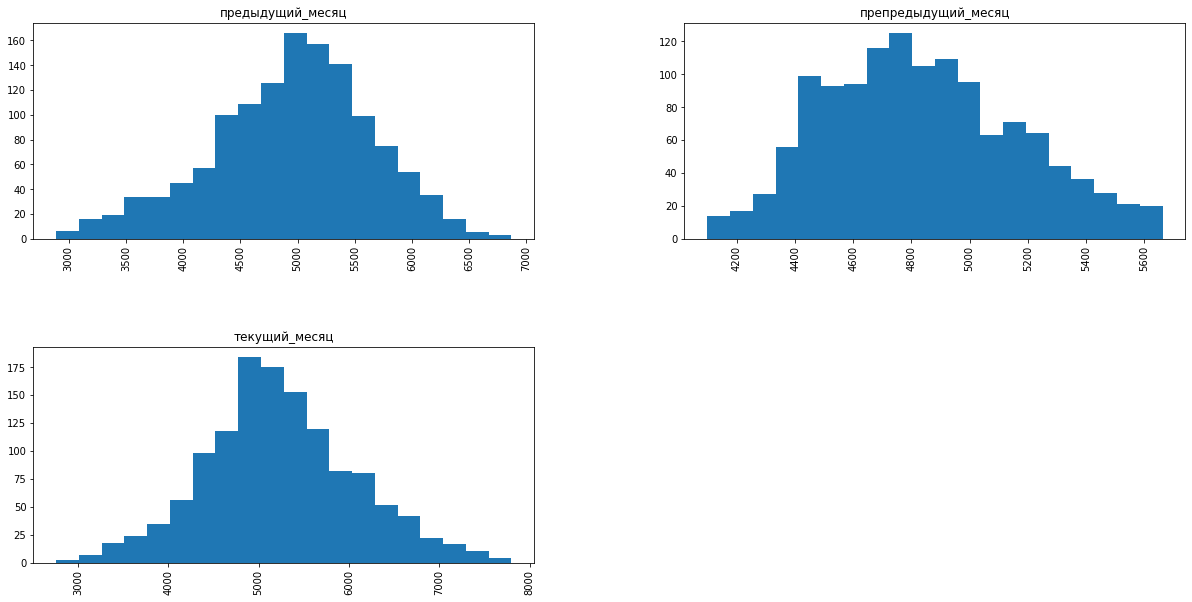

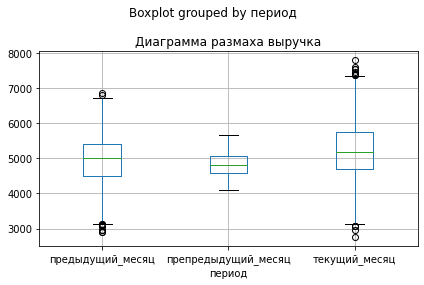

In [40]:
market_money = market_money[market_money['выручка'] != 0]

market_money.hist(bins=20, column='выручка', by='период', figsize=(20, 10))
plt.title(f'Гистограмма выручка')
plt.xlabel('выручка')
plt.ylabel('Частота')
        
market_money.boxplot(column='выручка', by='период')
plt.title(f'Диаграмма размаха выручка')

plt.tight_layout()
plt.show()

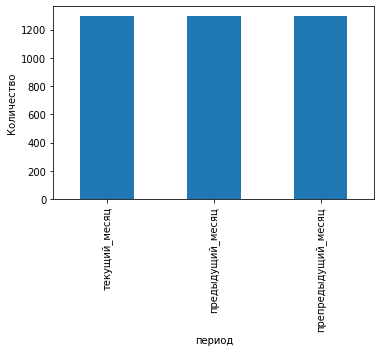

In [41]:
count_cat_plot(market_money)

В признаке "выручка" нашли и удалили выбросы. В категориальных - дисбаланса нет

### market_time

In [42]:
market_time.select_dtypes(include='number').drop('id', axis=1).describe()

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


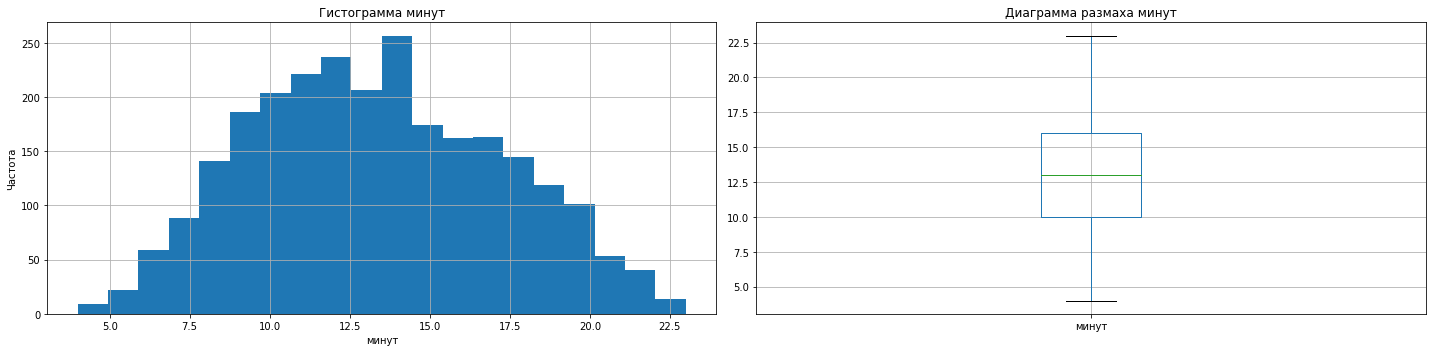

In [43]:
hist_boxplot(market_time)

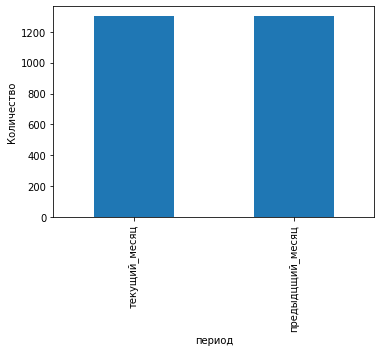

In [44]:
count_cat_plot(market_time)

Нет выбросов и дисбаланса значений

### money

In [45]:
money.drop('id', axis=1).describe()

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


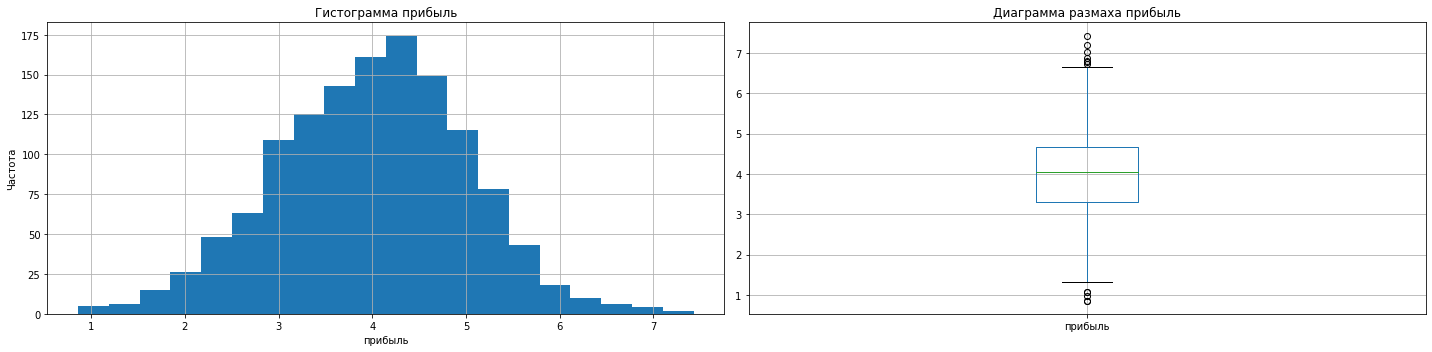

In [46]:
hist_boxplot(money)

Нет выбросов

### <font color='red'>Вывод</font><br>
<div class="alert alert-info">
1. В таблице 'market_file' есть выбросы и дисбаланс классов<br>
2. В таблице 'market_money' нашли выбросы и удалили их<br>
3. В таблицах 'market_time' и 'money' нет ни выбросов, ни дисбаланса классов

## Объединение таблиц

In [47]:
market_file = market_file.set_index('id')
market_money = market_money.set_index('id')
market_time = market_time.set_index('id')
money = money.set_index('id')

In [48]:
market_money_group = market_money.pivot_table(index=['id'], columns=['период'])
market_money_group.columns

MultiIndex([('выручка',    'предыдущий_месяц'),
            ('выручка', 'препредыдущий_месяц'),
            ('выручка',       'текущий_месяц')],
           names=[None, 'период'])

In [49]:
market_money_group.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_group.columns

Index(['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',
       'выручка_текущий_месяц'],
      dtype='object')

In [50]:
market_time_group = market_time.pivot_table(index=['id'], columns=['период'])
market_time_group.columns

MultiIndex([('минут', 'предыдцщий_месяц'),
            ('минут',    'текущий_месяц')],
           names=[None, 'период'])

In [51]:
market_time_group.columns = ['минут_предыдцщий_месяц', 'минут_текущий_месяц']
market_time_group.columns

Index(['минут_предыдцщий_месяц', 'минут_текущий_месяц'], dtype='object')

In [52]:
df_full = market_file.join(market_money_group, on='id')
df_full = df_full.join(market_time_group, on='id')

In [53]:
df_full.head(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдцщий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [54]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1300 non-null   object 
 1   тип_сервиса                          1300 non-null   object 
 2   разрешить_сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  ошибка_сервиса                       1300 non-null   int64  
 11  страниц_за_визит       

In [55]:
df_full.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               3
выручка_препредыдущий_месяц            3
выручка_текущий_месяц                  1
минут_предыдцщий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [56]:
df_full = df_full.dropna()
df_full.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
минут_предыдцщий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [57]:
df_full.duplicated().sum()

11

In [58]:
df_full[df_full.duplicated()].head(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдцщий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215895,Снизилась,стандарт,нет,4.4,5,517,0.23,Товары для детей,1,2,5,11,3130.0,4382.0,4345.5,11,12
215896,Снизилась,стандарт,нет,4.3,4,460,0.16,Техника для красоты и здоровья,2,1,3,6,4828.0,4822.0,4952.8,13,9
215897,Снизилась,стандарт,да,3.9,4,627,0.24,Товары для детей,3,3,7,8,5004.5,4460.0,5606.4,17,12
215898,Снизилась,стандарт,да,5.5,4,703,0.14,Мелкая бытовая техника и электроника,2,1,3,7,3428.0,4346.0,4353.6,18,11
215899,Снизилась,стандарт,нет,5.0,4,136,0.27,Товары для детей,3,4,4,17,4998.0,5230.0,5329.5,11,18


In [59]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

### <font color='red'>Вывод</font><br>
<div class="alert alert-info">
    Таблицы соединились хорошо, были пропущенные значения, которые удалили, есть дубликаты, но они не очень похожи на дубликаты,так как есть все таки отличия. Во всех столбцах типы данных соответствуют их значениям. В итоге получилась таблица размером (1296, 17), где 17 это количество столбцов и 1296 - количество строк

## Корреляционный анализ

In [60]:
interval_cols = df_full.select_dtypes(include='number').columns.tolist()
df_full[interval_cols].corr(method='spearman')

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдцщий_месяц,минут_текущий_месяц
маркет_актив_6_мес,1.000000,0.061741,-0.044445,-0.276590,0.185013,-0.135045,0.038643,0.319872,-0.003642,0.234728,0.002093,0.273727,0.226968
маркет_актив_тек_мес,0.061741,1.000000,-0.131967,0.033099,-0.025167,0.061747,0.087343,0.003143,-0.027088,-0.039437,-0.011782,0.013535,-0.063051
длительность,-0.044445,-0.131967,1.000000,0.029045,-0.043154,-0.108787,0.103562,-0.034495,0.013537,-0.039301,0.015002,-0.123940,0.083048
акционные_покупки,-0.276590,0.033099,0.029045,1.000000,-0.203401,0.198307,-0.051593,-0.370860,0.005184,-0.269087,0.022255,-0.332548,-0.275313
средний_просмотр_категорий_за_визит,0.185013,-0.025167,-0.043154,-0.203401,1.000000,-0.251559,0.010034,0.267479,-0.049460,0.149742,-0.070716,0.148279,0.233369
неоплаченные_продукты_штук_квартал,-0.135045,0.061747,-0.108787,0.198307,-0.251559,1.000000,-0.098582,-0.165412,0.033434,-0.249293,0.061178,-0.183575,-0.214699
ошибка_сервиса,0.038643,0.087343,0.103562,-0.051593,0.010034,-0.098582,1.000000,0.104482,0.035476,0.090152,0.040477,0.196009,0.078074
страниц_за_визит,0.319872,0.003143,-0.034495,-0.370860,0.267479,-0.165412,0.104482,1.000000,-0.067610,0.311675,-0.049964,0.450760,0.298120
выручка_предыдущий_месяц,-0.003642,-0.027088,0.013537,0.005184,-0.049460,0.033434,0.035476,-0.067610,1.000000,0.308041,0.879097,-0.084215,-0.083214
выручка_препредыдущий_месяц,0.234728,-0.039437,-0.039301,-0.269087,0.149742,-0.249293,0.090152,0.311675,0.308041,1.000000,0.149944,0.348745,0.299783


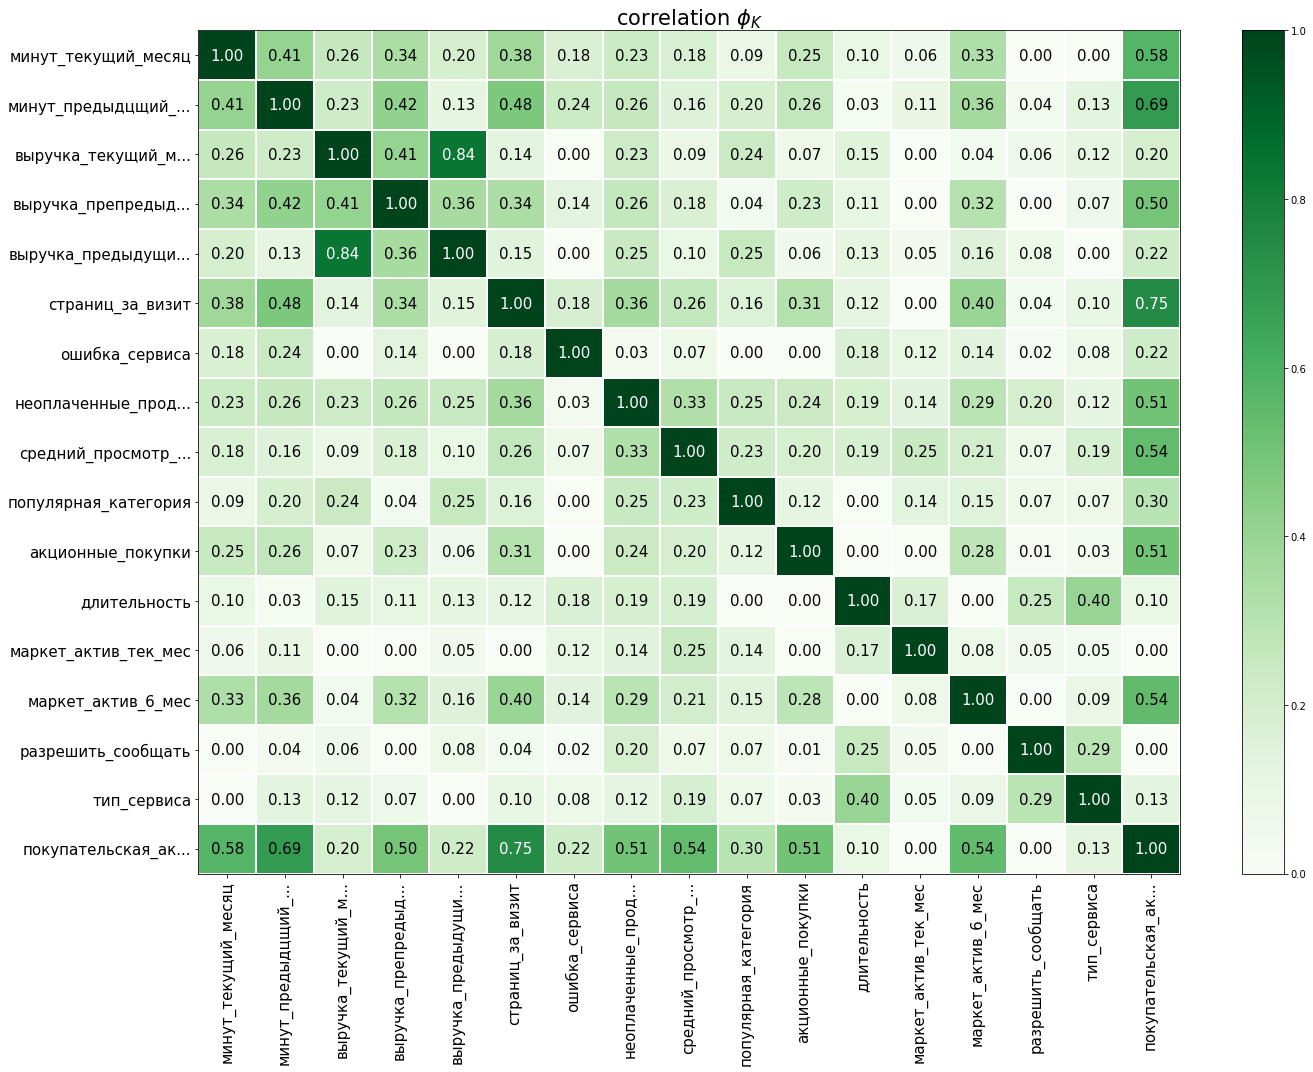

In [61]:
phik_overview = phik.phik_matrix(df_full, interval_cols=interval_cols)
phik.report.plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### <font color='red'>Вывод</font><br>
<div class="alert alert-info">

Мультиколлинеарность - это явление, при котором наблюдается сильная связь между входными признаками. Наличие мультиколлинеарности приводит к нестабильности весовых коэффициентов взаимосвязанных входных признаков, что делает модель менее точной.<br>
В нашем случае таких признаков нет.<br>
    
У целевого признака хорошая взавимосвзяь с признаками:<br>

1. "минут_текущий_месяц" время проведенное на сайте - 0.58
2. "минут_предыдущий_месяц" время проведенное на сайте - 0.69
2. "страниц_за_визит" среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца -0.75

## Пайплайны

In [62]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [63]:
df_full['категории_ошибка_сервиса'] = df_full['ошибка_сервиса'].apply(
    lambda x: 'хорошо' if (x<=2)
    else ('плохо' if (3<=x<6)
    else 'очень_плохо')
)
df_full = df_full.drop('ошибка_сервиса', axis=1)
df_full.head(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдцщий_месяц,минут_текущий_месяц,категории_ошибка_сервиса
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,5,5216.0,4472.0,4971.6,12,10,хорошо
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,5,5457.5,4826.0,5058.4,8,13,хорошо
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,4,6158.0,4793.0,6610.4,11,13,очень_плохо
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,2,5807.5,4594.0,5872.5,8,11,плохо
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,4,4738.5,5124.0,5388.5,10,10,хорошо


In [64]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  страниц_за_визит                     1296 non-null   int64  
 11  выручка_предыдущий_меся

In [65]:
label_encoder = LabelEncoder()
X = df_full.drop('покупательская_активность', axis=1)
y = df_full['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
label_encoder.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

In [66]:
ohe_columns = df_full.select_dtypes(include='object').drop(
    columns=['покупательская_активность', 'категории_ошибка_сервиса'], axis=1).columns.tolist()
ord_columns = ['категории_ошибка_сервиса']
num_columns = df_full.select_dtypes(include='number').columns.tolist()
num_columns

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'страниц_за_визит',
 'выручка_предыдущий_месяц',
 'выручка_препредыдущий_месяц',
 'выручка_текущий_месяц',
 'минут_предыдцщий_месяц',
 'минут_текущий_месяц']

In [67]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

In [68]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=np.nan,
            categories=[
            [
                'хорошо', 'плохо', 'очень_плохо'
            ]
        ])),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [69]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [70]:
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [71]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [72]:
randomized_search = RandomizedSearchCV(
    final_pipe, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Выбрали метрику ROC-AUC, так как значений одного класса больше второго

In [73]:
randomized_search.fit(X_train, y_train)
y_pred = randomized_search.predict(X_test)
y_pred_proba = randomized_search.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [74]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc}')
print(f'F1 score {f1_score(y_test, y_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpl

### <font color='red'>Вывод</font><br>
<div class="alert alert-info">
Лучшая модель получилась с такими гиперпараметрами:<br>
    DecisionTreeClassifier(max_depth=9, min_samples_leaf=7, min_samples_split=11, random_state=42)

## Анализ важности признаков

In [75]:
model = randomized_search.best_estimator_.named_steps['models']
model

DecisionTreeClassifier(max_depth=9, min_samples_leaf=7, min_samples_split=11,
                       random_state=42)

In [76]:
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['тип_сервиса', 'разрешить_сообщать',
                                  'популярная_категория']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')...
                                 ['категории_ошибка_сервиса']),
                                ('num', MinMaxScaler(),
                                 ['маркет_актив_6_мес', 'маркет_актив_тек_мес',
                                  'длительность', 'акционные_покупки',
                                  'средний_просмотр_категорий_за_визит',
                                  'неоплаченные_продукты_штук_квартал',
                                  'страниц_за_визит',
                                  'выручка_предыдущий_месяц',
                                  'выручка_препредыдущий_месяц',
                                  'выручка_текущий_месяц',
                                  'минут_предыдцщий_месяц',
                                  'минут_текущий_месяц'])])

In [77]:
X_train_preprocessor = preprocessor.fit_transform(X_train)
X_test_preprocessor = preprocessor.transform(X_test)

In [78]:
features_names_cols = preprocessor.get_feature_names_out().tolist()
features_names_cols

['ohe__тип_сервиса_стандарт',
 'ohe__разрешить_сообщать_нет',
 'ohe__популярная_категория_Косметика и аксесуары',
 'ohe__популярная_категория_Кухонная посуда',
 'ohe__популярная_категория_Мелкая бытовая техника и электроника',
 'ohe__популярная_категория_Техника для красоты и здоровья',
 'ohe__популярная_категория_Товары для детей',
 'ord__категории_ошибка_сервиса',
 'num__маркет_актив_6_мес',
 'num__маркет_актив_тек_мес',
 'num__длительность',
 'num__акционные_покупки',
 'num__средний_просмотр_категорий_за_визит',
 'num__неоплаченные_продукты_штук_квартал',
 'num__страниц_за_визит',
 'num__выручка_предыдущий_месяц',
 'num__выручка_препредыдущий_месяц',
 'num__выручка_текущий_месяц',
 'num__минут_предыдцщий_месяц',
 'num__минут_текущий_месяц']

In [83]:
X_train_preprocess_df = pd.DataFrame(X_train_preprocessor, columns=features_names_cols)
X_test_preprocess_df = pd.DataFrame(X_test_preprocessor, columns=features_names_cols)
X_train_preprocess_df.shape, X_test_preprocess_df.shape

((972, 20), (324, 20))

In [84]:
model.fit(X_train_preprocess_df, y_train)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=7, min_samples_split=11,
                       random_state=42)

PermutationExplainer explainer: 325it [00:14,  9.19it/s]                         
/opt/conda/lib/python3.9/site-packages/shap/plots/_beeswarm.py:962: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  pl.tight_layout()


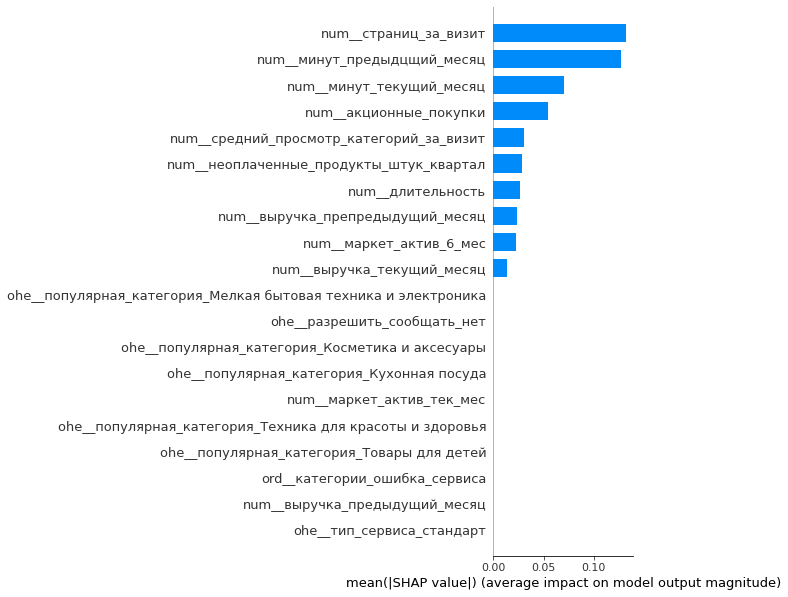

In [85]:
explainer = shap.Explainer(model.predict, X_train_preprocess_df)
shap_values = explainer(X_test_preprocess_df)
shap.summary_plot(shap_values, X_test_preprocess_df, plot_type="bar", plot_size=(2.5, 10.1))

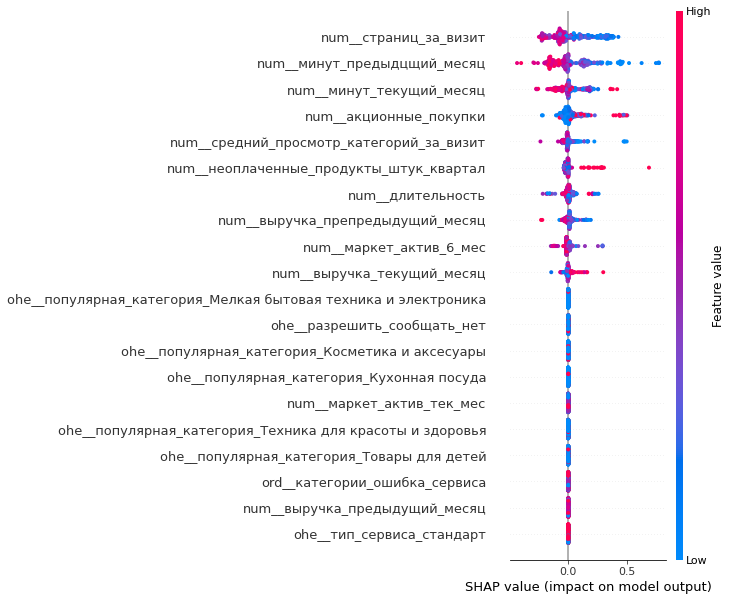

In [86]:
shap.summary_plot(shap_values, X_test_preprocess_df, plot_size=(3.5, 10.1))

### <font color='red'>Вывод</font><br>
<div class="alert alert-info">
    
Как видно из графика наиболее важные признаки:
1. "страниц_за_визит"
2. "минут"
3. "акционные_покупки"
    
Наименее важные признаки:
1. "выручка_препредыдущий_месяц"
2. "тип_сервиса"
3. "категории_ошибка сервиса"

Покупательная активность пользователя снизится,если:
1. уменьшится количество просмотров "страниц_за_визит"
2. уменьшится количество "минут" проведенных на сайте
3. увеличится количество покупок товаров по акции
4. уменьшится "среднее количество просмотров категорий за визит"

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

## Сегментация покупателей

In [87]:
predictions_train = randomized_search.best_estimator_.predict_proba(X_train)[:, 1]
predictions_test = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]
#predictions = ['снизилась' if x==True else 'прежний_уровень' for x in predictions]

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [88]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train_copy['predictions'] = predictions_train
X_test_copy['predictions'] = predictions_test
df_full = pd.concat([X_train_copy, X_test_copy])
df_full = df_full.join(money)
df_full.head(5)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдцщий_месяц,минут_текущий_месяц,категории_ошибка_сервиса,predictions,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,16,5170.5,4347.0,6014.2,20,6,очень_плохо,0.059155,4.37
215361,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,3,6400.0,4597.0,3789.7,11,13,хорошо,1.000000,4.03
215884,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,11,4113.0,4626.0,3798.4,13,10,плохо,0.059155,4.37
216564,стандарт,да,5.6,4,342,0.94,Кухонная посуда,2,7,8,4930.0,5269.0,4766.2,14,19,плохо,0.333333,5.58
215715,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,5,3716.0,4691.0,4600.0,10,10,хорошо,1.000000,4.87


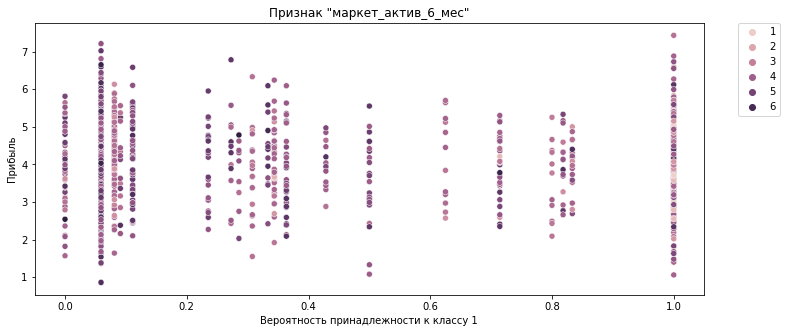

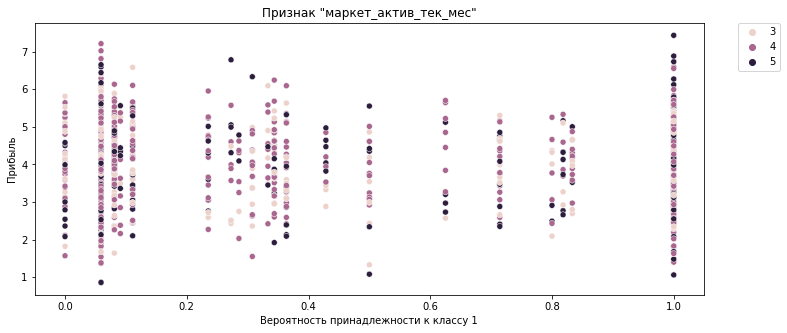

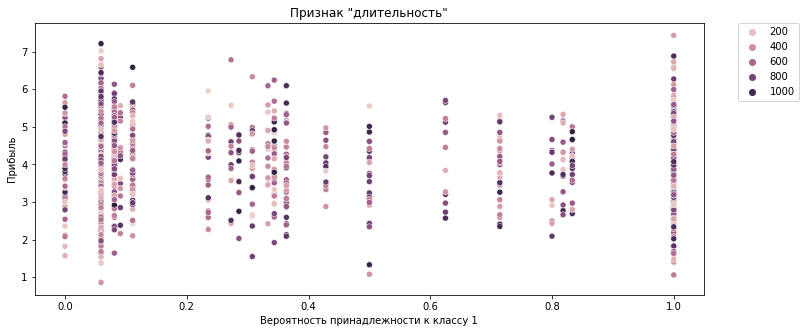

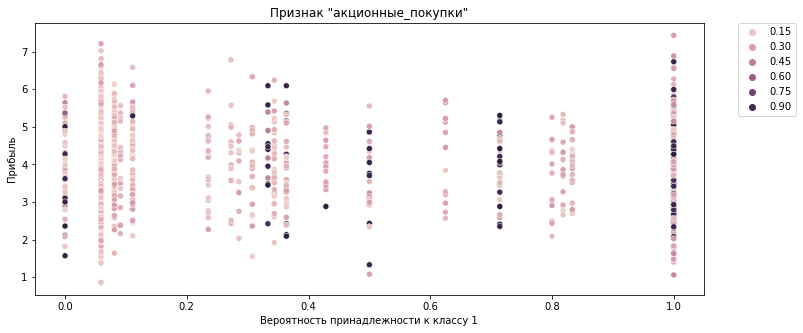

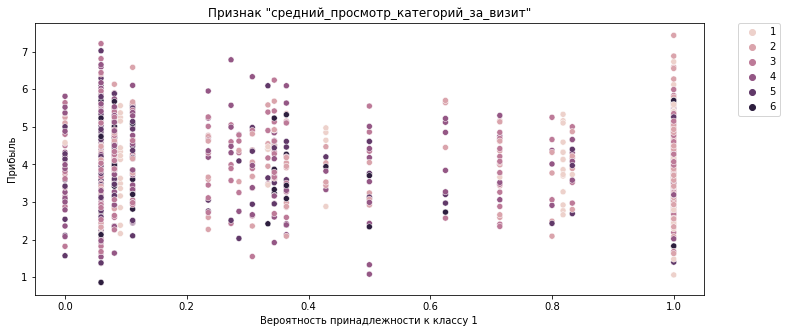

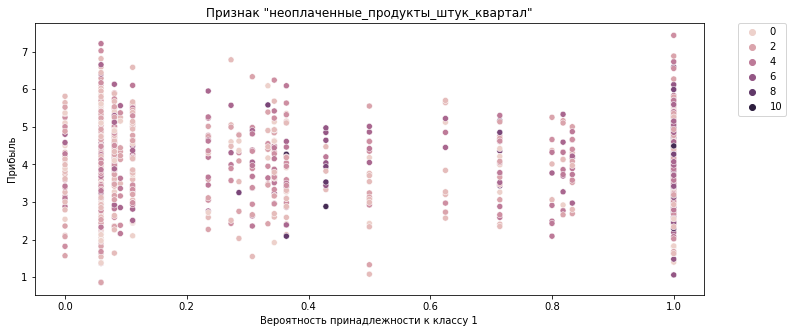

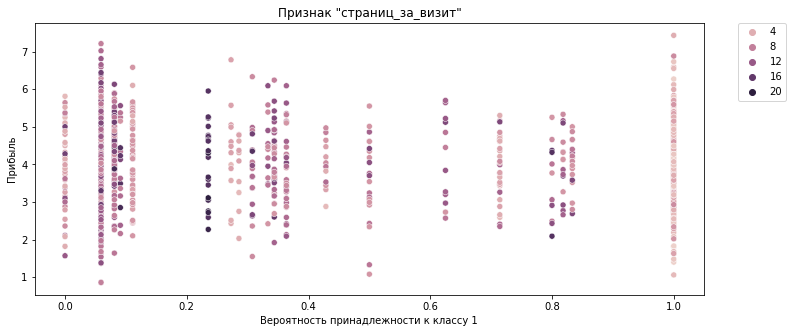

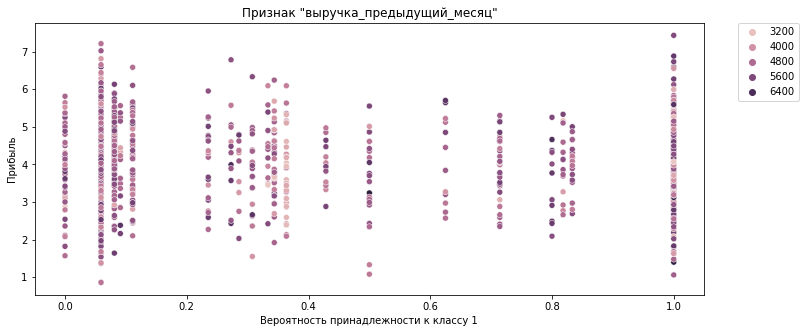

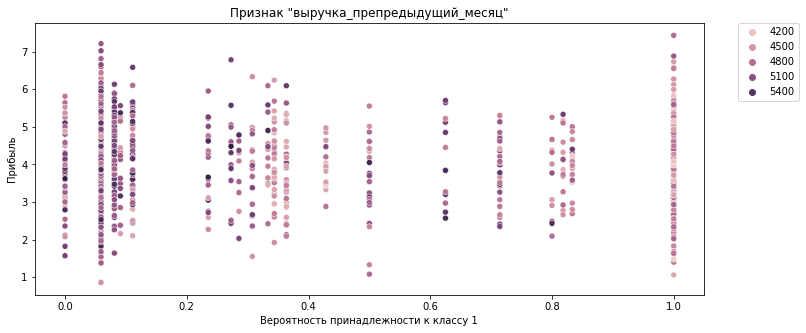

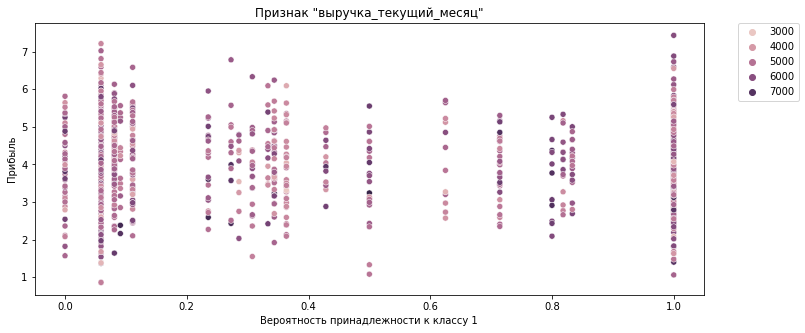

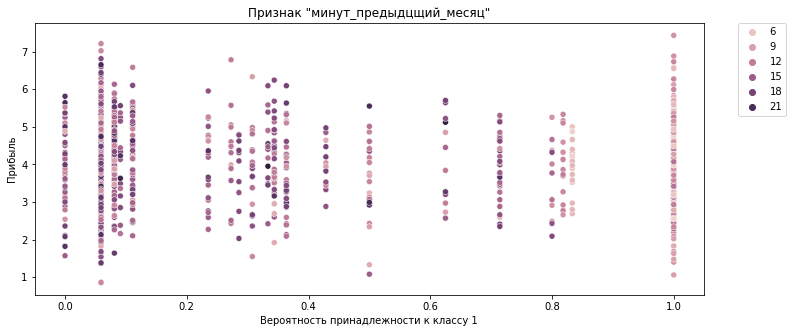

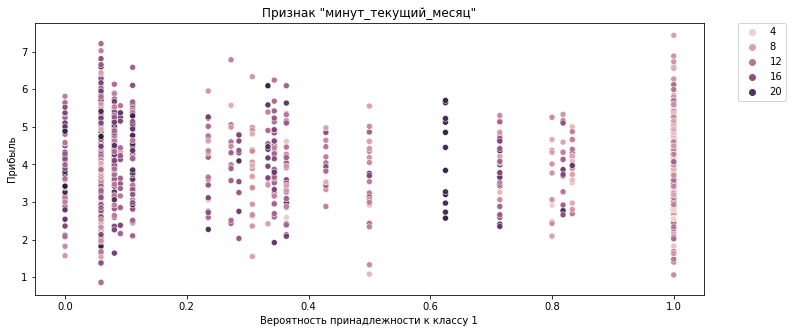

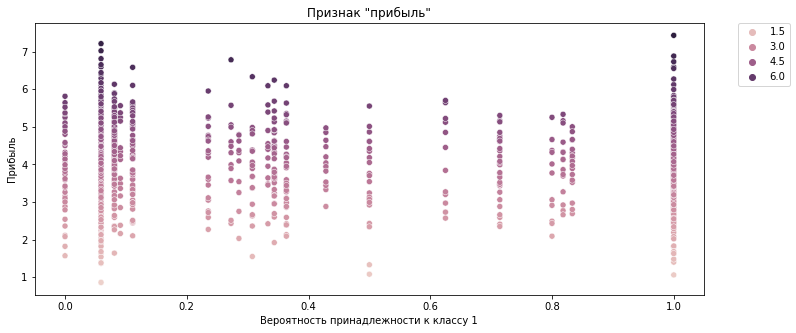

In [89]:
num_cols = df_full.select_dtypes(include='number').drop('predictions', axis=1).columns.tolist()
for name in num_cols:
    plt.figure(figsize=(12, 5))
    plt.title(f'Признак "{name}"')
    plt.xlabel('Вероятность принадлежности к классу 1')
    plt.ylabel(f'Прибыль')
    sns.scatterplot(
        data=df_full,
        x='predictions',
        y='прибыль',
        hue=df_full[name]
    )
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
    plt.show()

Судя по графикам на прибыль никак не влияет "пользовательская активность". Выберем категорию пользователей по наиболее важным принакам, у которой больше всего вероятность принадлежности к классу 1 ("снизилась" пользовательская активность). Судя по графикам порог нужно установить 0.75.

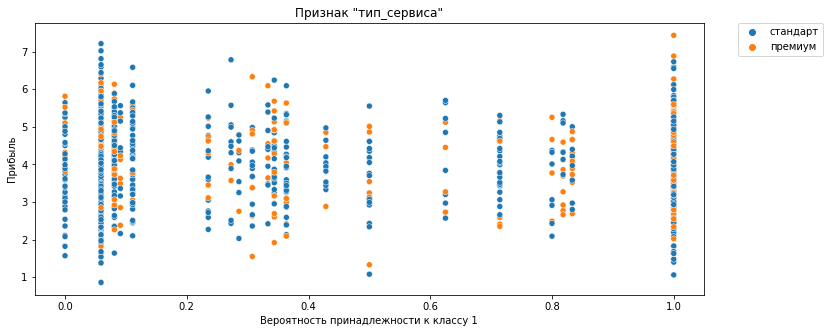

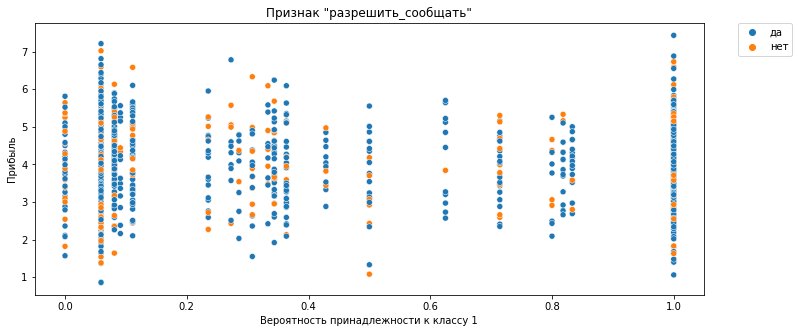

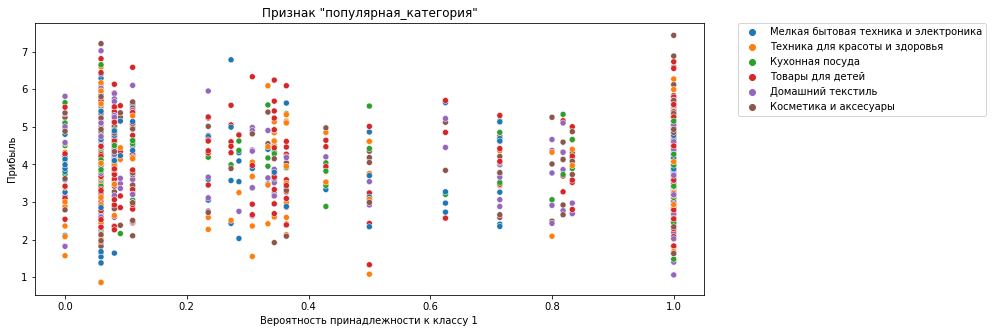

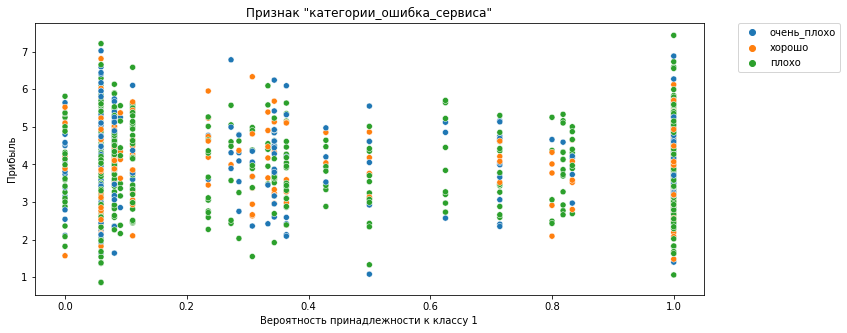

In [90]:
cat_cols = df_full.select_dtypes(exclude='number').columns.tolist()
for name in cat_cols:
    plt.figure(figsize=(12, 5))
    plt.title(f'Признак "{name}"')
    plt.xlabel('Вероятность принадлежности к классу 1')
    plt.ylabel(f'Прибыль')
    sns.scatterplot(
        data=df_full,
        x='predictions',
        y='прибыль',
        hue=df_full[name]
    )
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
    plt.show()

По графикам нет зависимости прибыли от "пользовательской активности", как и нельзя установить порог принадлежности к классу 1

In [91]:
df_decreased = df_full[df_full['predictions'] > 0.75]
df_decreased.head(5)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдцщий_месяц,минут_текущий_месяц,категории_ошибка_сервиса,predictions,прибыль
id,,,,,,,,,,,,,,,,,,
215361,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,3,6400.0,4597.0,3789.7,11,13,хорошо,1.0,4.03
215715,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,5,3716.0,4691.0,4600.0,10,10,хорошо,1.0,4.87
215674,стандарт,да,3.0,4,304,0.25,Домашний текстиль,1,6,3,4789.5,4305.0,4762.2,11,11,плохо,1.0,2.72
215451,стандарт,да,3.9,3,1048,0.22,Товары для детей,4,5,5,4043.0,4658.0,4260.1,11,14,плохо,1.0,5.31
215656,стандарт,да,3.8,5,217,0.39,Косметика и аксесуары,2,2,4,4497.0,4227.0,5642.3,7,10,плохо,1.0,3.25


In [92]:
df_decreased.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 215361 to 215670
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип_сервиса                          376 non-null    object 
 1   разрешить_сообщать                   376 non-null    object 
 2   маркет_актив_6_мес                   376 non-null    float64
 3   маркет_актив_тек_мес                 376 non-null    int64  
 4   длительность                         376 non-null    int64  
 5   акционные_покупки                    376 non-null    float64
 6   популярная_категория                 376 non-null    object 
 7   средний_просмотр_категорий_за_визит  376 non-null    int64  
 8   неоплаченные_продукты_штук_квартал   376 non-null    int64  
 9   страниц_за_визит                     376 non-null    int64  
 10  выручка_предыдущий_месяц             376 non-null    float64
 11  выручка_препредыдущий_ме

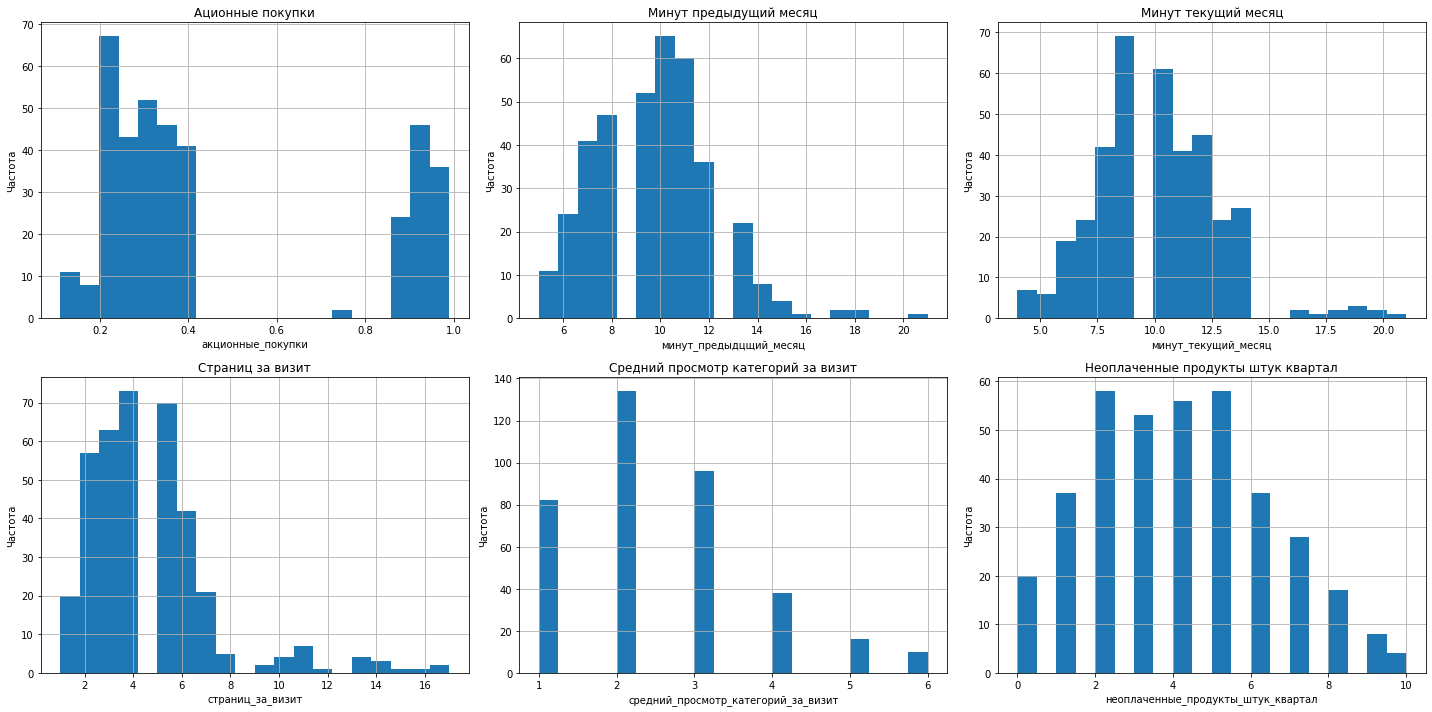

In [93]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
df_decreased['акционные_покупки'].hist(bins=20)
plt.xlabel('акционные_покупки')
plt.ylabel('Частота')
plt.title('Ационные покупки')

plt.subplot(2, 3, 2)
df_decreased['минут_предыдцщий_месяц'].hist(bins=20)
plt.xlabel('минут_предыдцщий_месяц')
plt.ylabel('Частота')
plt.title('Минут предыдущий месяц')

plt.subplot(2, 3, 3)
df_decreased['минут_текущий_месяц'].hist(bins=20)
plt.xlabel('минут_текущий_месяц')
plt.ylabel('Частота')
plt.title('Минут текущий месяц')

plt.subplot(2, 3, 4)
df_decreased['страниц_за_визит'].hist(bins=20)
plt.title('Страниц за визит')
plt.xlabel('страниц_за_визит')
plt.ylabel('Частота')

plt.subplot(2, 3, 5)
df_decreased['средний_просмотр_категорий_за_визит'].hist(bins=20)
plt.title('Средний просмотр категорий за визит')
plt.xlabel('средний_просмотр_категорий_за_визит')
plt.ylabel('Частота')

plt.subplot(2, 3, 6)
df_decreased['неоплаченные_продукты_штук_квартал'].hist(bins=20)
plt.title('Неоплаченные продукты штук квартал')
plt.xlabel('неоплаченные_продукты_штук_квартал')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

### <font color='red'>Вывод</font><br>
<div class="alert alert-info">
    
Выбрали сегмент пользователей с параметрами которые сильнее всего влияют на снижение покупательской активности. Как видно из графиков пользователи данного сегмента очень мало проводят времени на сайте и просматривают малое количество страниц, категорий товаров.

Предлагается увеличить количество товаров, и как следствие расширишить категории товаров, под покупки по акции, которые находятся в корзине пользователей.

## Общий вывод

Работа над проектом проводилась в несколько этапов:</p>
1. Загрузили данные и ознакомились с ними
2. Сделали предобработку данных
3. Провели исследовательский анализ
4. Объединили данные
5. Корреляционный анализ
6. Создали пайплайны
7. Провели обучение 4 моделей машинного обучения - LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, SVC - с различными гиперпараметрами
8. Нашли лучшую модель - DecisionTreeClassifier
9. Проанализировали признаки по важности
10. Провели сегментацию пользователей

Лучшая модель получилась такая:
<font color='red'>DecisionTreeClassifier(max_depth=9, min_samples_leaf=7, min_samples_split=11, random_state=42)</font><br>
Метрики:
1. ROC-AUC - 0.91
2. F1-score - 0.83

Наиболее важные признаки:
1. "страниц_за_визит"
2. "минут"
3. "акционные_покупки"
    
Наименее важные признаки:
1. "период_money_препредыдущий_месяц"
2. "период_money_текущий_месяц"
3. "период_time_текущий_месяц"

Покупательная активность пользователя снизится,если:
1. уменьшится количество просмотров "страниц_за_визит"
2. уменьшится количество "минут" проведенных на сайте
3. увеличится количество покупок товаров по акции
4. уменьшится "среднее количество просмотров категорий за визит"

Предложение как увеличить покупательскую активность пользователей:

<font color='red'>Увеличить количество товаров, и как следствие расширишить категории товаров, под покупки по акции, которые находятся в корзине пользователей.</font>